In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.models as models
from collections import OrderedDict
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from model import Model

from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader

from dataset import TestDataset, DIPLECSTestDataset
from config import CONFIG
from attrdict import AttrDict
import yaml
import cv2

In [3]:
model = Model.load_from_checkpoint(checkpoint_path="lightning_logs/version_0/checkpoints/epoch=16-val_loss=0.1223.ckpt", strict=False)


In [8]:
device = 'cuda:0'

model.eval()
model.to(device)

num_workers = 11

val_df = pd.read_csv('data/val_norm_denoised.csv')
val_dataset = TestDataset('data/val/', val_df)

# val_df = pd.read_csv("./PShape/test_1315585148/1315585148.csv")
# val_dataset = TestDataset("PShape/test_1315585148/1315585148", val_df, resize=(320, 240))

val_loader = DataLoader(
    val_dataset, 
    batch_size=1, 
    shuffle=False, 
    drop_last=False, 
    num_workers=num_workers, 
    pin_memory=True)

In [9]:
Y = []
tokens = []

frames_cache = []
angles_cache = []


for batch in tqdm(val_loader):
  
    img, _ = batch 
    img = img.to(device)
                    
    """
    img: (1, 3, w, h)
    """
    x = model.backbone(img)
    frames_cache.append(x)

    if len(frames_cache) < model.hparams.seq_l:

        angles_cache.append(torch.FloatTensor([0]).type_as(img))
        Y.append(0)
        continue

    x = torch.stack(frames_cache, dim=1)

    steer_angles = torch.stack(angles_cache).T
    
    steer_tokens = model.tokenize(steer_angles)
    
#     print(steer_tokens.shape, steer_tokens)
#     assert False
    y_hat = model.decoder(x, steer_tokens)
    y_hat = torch.clamp(y_hat, -1.0, 1.0)
    Y.append(y_hat.detach().cpu().item())

    angles_cache.append(y_hat)
    angles_cache = angles_cache[1:]

    frames_cache = frames_cache[1:]
    
y = np.array(Y)

  0%|          | 0/1219 [00:00<?, ?it/s]

RuntimeError: The size of tensor a (31) must match the size of tensor b (81) at non-singleton dimension 0

(1347,) (1347,)


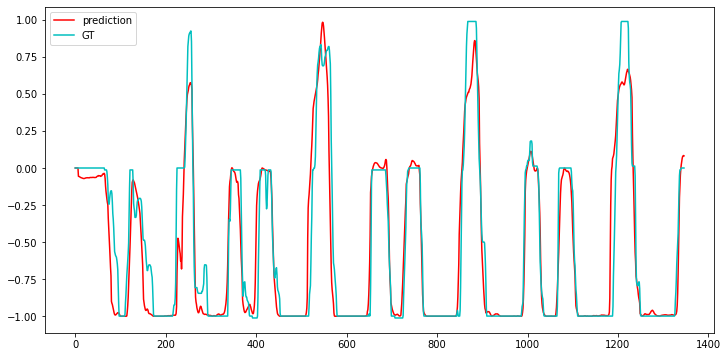

0.11234974303316897

In [7]:
data = val_df.steer.to_numpy().flatten()

# y_t = pd.read_csv('test/0.0742.txt', header=None).to_numpy().flatten()
y_train = y.flatten().round(4)
# jetson_pred = pd.read_csv('val_pred.csv')

print(data.shape, y.shape)
assert len(data) == len(y)

s = 0
e = 2000

fig = plt.figure(figsize=(12,6))
ax  = fig.add_subplot(111)
ax.plot(y_train[s:e], c='r', label='prediction', linewidth=1.5)
ax.plot(data[s:e], c='c', label='GT', linewidth=1.5)
# ax.plot(jetson_pred[s:e], c='b', label='pred', linewidth=1.5)

# ax.plot(t[s:e], c='g', label='tokens', linewidth=2)

leg = plt.legend()
plt.show()

np.abs(y - data).mean()#, np.abs(y_train - y_t).sum()

(<AxesSubplot:>, <AxesSubplot:>)

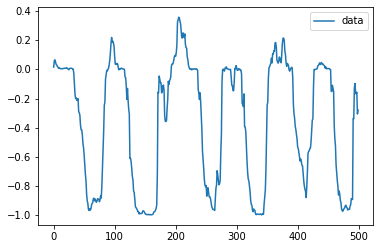

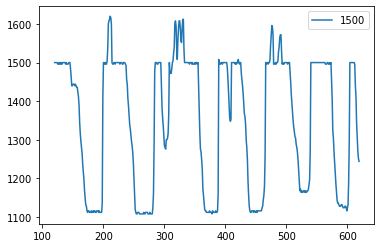

In [42]:
df = pd.read_csv('val_pred.csv')
val_df = pd.read_csv('val.csv')
s = 120
df[:500].plot(), val_df[s:s+500].plot()

In [16]:
y_denoised[:10], model.encoder.fc.bias

(array([0.04138161, 0.02665709, 0.04567354, 0.04297645, 0.018864  ,
        0.0218231 , 0.03834907, 0.03252573, 0.03297827, 0.03292776]),
 Parameter containing:
 tensor([-0.0406], device='cuda:0', requires_grad=True))

In [25]:
class TestDataset(Dataset):

    def __init__(self, data_dir, prefix):

        self.prefix = prefix
        self.data_dir = data_dir
        
        self.transform = transforms.Compose([
#             transforms.Resize(120,320),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        
        
        
    def __len__(self):
        return 1350
     
    def __getitem__(self, index):
        

        img_index = str(index+1).zfill(6)

        img_path = self.data_dir + self.prefix + "Image" + img_index + '.jpg'
        img = cv2.imread(img_path)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (320, 240,))
        x = self.transform(img)
                
        return x
    
device = 'cuda:0'

model.eval()
model.to(device)

num_workers = 11
epochs = CONFIG.epochs

val_dataset = TestDataset("PShape/train_1315584123/", "1315584123")
val_loader = DataLoader(
    val_dataset, 
    batch_size=1, 
    shuffle=False, 
    drop_last=True, 
    num_workers=num_workers, 
    pin_memory=True)

<AxesSubplot:>

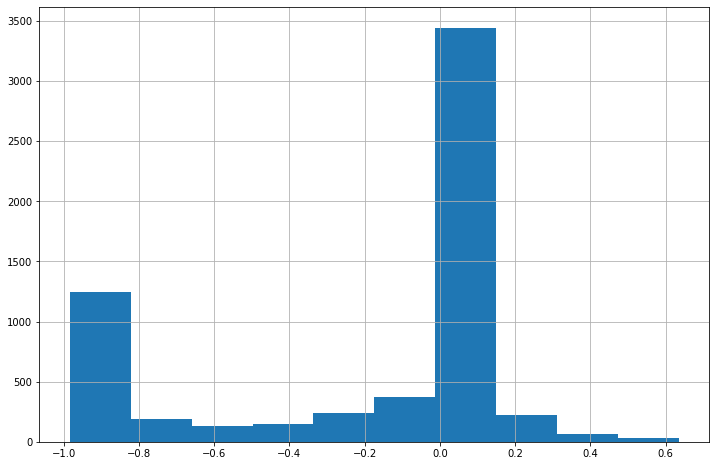

In [23]:
import seaborn as sns
df = pd.read_csv('data/train_norm_denoised.csv')

plt.figure(figsize=(12,8))
df.steer.hist()

([<matplotlib.lines.Line2D at 0x7f8583e30f10>],
 21,
 array([-1.05, -0.95, -0.85, -0.75, -0.65, -0.55, -0.45, -0.35, -0.25,
        -0.15, -0.05,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,
         0.75,  0.85,  0.95]))

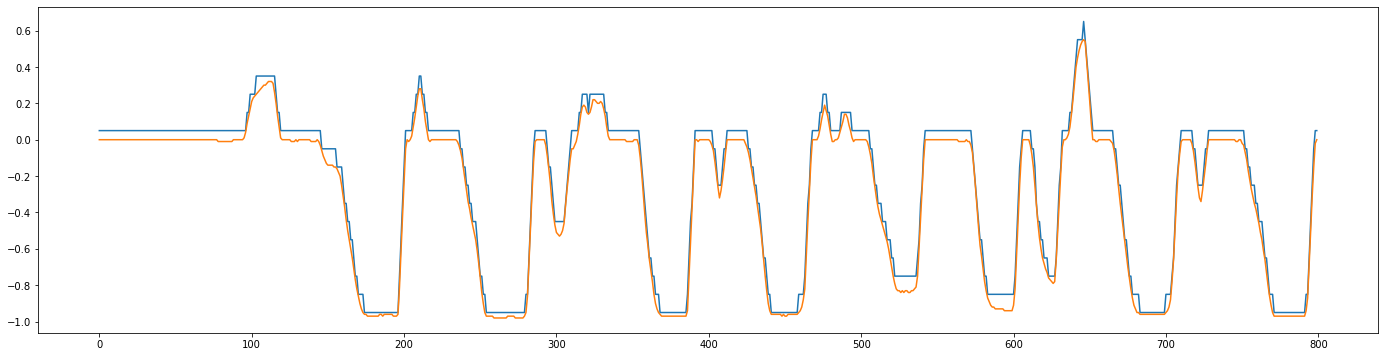

In [34]:
stride = 0.1
bins = np.arange(-1-stride/2, 1+stride/2,stride)
digitized = np.digitize(df,bins)

# x = ((bins[digitized-1] + bins[digitized]) / 2)[:800]
x = bins[digitized][:800]

fig = plt.figure(figsize=(24,6))
ax  = fig.add_subplot(111)
ax.plot(x), x[:10]

df = pd.read_csv('data/val_norm_denoised.csv')
target = torch.from_numpy(df.to_numpy())
data = target.flatten().float()
ax.plot(target[:800]), len(bins), bins


In [75]:
np.digitize(0,bins)

11

(array([ 959.,  184.,  149.,  142.,  143.,  208., 1341.,  177.,   78.,
          20.]),
 array([  3. ,  18.2,  33.4,  48.6,  63.8,  79. ,  94.2, 109.4, 124.6,
        139.8, 155. ]),
 <BarContainer object of 10 artists>)

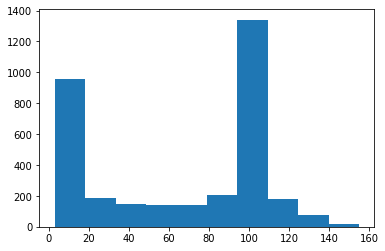

In [56]:
plt.hist(np.digitize(df,bins))

In [5]:
import timm
resnet = timm.create_model(CONFIG.backbone, pretrained=True) 
resnet = nn.Sequential(*list(resnet.children())[:-1])
resnet(torch.rand(1,3,224,224)).shape

torch.Size([1, 4096, 1, 1])